In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from math import sqrt

In [8]:
ticker = "MSFT"
start_date = '2018-01-01'
end_date = '2023-10-31'

In [9]:
df = yf.download(ticker, start_date, end_date).reset_index()
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
0    2018-01-02   86.129997   86.309998   85.500000   85.949997   80.229004   
1    2018-01-03   86.059998   86.510002   85.970001   86.349998   80.602379   
2    2018-01-04   86.589996   87.660004   86.570000   87.110001   81.311806   
3    2018-01-05   87.660004   88.410004   87.430000   88.190002   82.319923   
4    2018-01-08   88.199997   88.580002   87.599998   88.279999   82.403931   
...         ...         ...         ...         ...         ...         ...   
1462 2023-10-24  331.299988  331.839996  327.600006  330.529999  329.860504   
1463 2023-10-25  345.019989  346.200012  337.619995  340.670013  339.979980   
1464 2023-10-26  340.540009  341.630005  326.940002  327.890015  327.225861   
1465 2023-10-27  330.429993  336.720001  328.399994  329.809998  329.141968   
1466 2023-10-30  333.410004  339.450012  331.829987  337.309998  336.626770   

        Volume  
0     22483800  
1     26061400  
2     21912000  
3     23407100  
4     22113000  
...        ...  
1462  31153600  
1463  55053800  
1464  37828500  
1465  29856500  
1466  22828100  

[1467 rows x 7 columns]

In [10]:
data = df['Close']

scaler = MinMaxScaler()
data = scaler.fit_transform(data.values.reshape(-1, 1))

In [11]:
training_data_len = int(len(data) * 0.8)
training_data = data[0:training_data_len, :]
testing_data = data[training_data_len:, :]

len(training_data), len(testing_data)

(1173, 294)

In [12]:
past_values = 1

def create_training_data(data, past_values):
    if len(data) < past_values:
        return np.array([]), np.array([])
    X_train = []
    y_train = []
    for i in range(past_values, len(data)):
        X_train.append(data[i-past_values:i, 0])
        y_train.append(data[i, 0])
    return np.array(X_train), np.array(y_train)

X_train, y_train = create_training_data(training_data, past_values)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test, y_test = create_training_data(testing_data, past_values)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [13]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=200, epochs=200, verbose=0)

In [14]:
pred_train = model.predict(X_train)
pred = model.predict(X_test)

10/10 [==============================] - 0s 5ms/step


In [15]:
pred_train = scaler.inverse_transform(pred_train)
pred = scaler.inverse_transform(pred)
y_test = scaler.inverse_transform([y_test])
y_train = scaler.inverse_transform([y_train])

In [16]:
y_test = y_test.flatten()
y_train = y_train.flatten()

In [17]:
print("Training Error")
mae = mean_absolute_error(y_train, pred_train)
print("Mean Absolute Error (MAE):", mae)
rmse = sqrt(mean_squared_error(y_train, pred_train))
print("Root Mean Squared Error (RMSE):", rmse)
    
plt.plot(y_train, label = 'actual '+str(ticker))
plt.plot(pred_train, label = 'predicted '+str(ticker))
plt.title("Training Plot")
plt.legend()
plt.show()

Training Error
Mean Absolute Error (MAE): 2.579230813036191
Root Mean Squared Error (RMSE): 3.7993182355791526


In [18]:
print("Testing Error")
mae = mean_absolute_error(y_test, pred)
print("Mean Absolute Error (MAE):", mae)
rmse = sqrt(mean_squared_error(y_test, pred))
print("Root Mean Squared Error (RMSE):", rmse)

plt.plot(y_test, label = 'actual '+str(ticker))
plt.plot(pred, label = 'predicted '+str(ticker))
plt.title("Testing Plot")
plt.legend()
plt.show()

Testing Error
Mean Absolute Error (MAE): 3.964527377496399
Root Mean Squared Error (RMSE): 5.161385222767155


In [19]:
y_test[-1]

337.30999755859375

In [21]:
pred[-1]

array([329.79504], dtype=float32)

In [24]:
start_date = '2023-11-01'
end_date = '2023-12-08'
future_data = yf.download(ticker, start_date, end_date).reset_index()['Close']
future_data

[*********************100%***********************]  1 of 1 completed


0     346.070007
1     348.320007
2     352.799988
3     356.529999
4     360.529999
5     363.200012
6     360.690002
7     369.670013
8     366.679993
9     370.269989
10    369.670013
11    376.170013
12    369.850006
13    377.440002
14    373.070007
15    377.850006
16    377.429993
17    378.609985
18    382.700012
19    378.850006
20    378.910004
21    374.510010
22    369.140015
23    372.519989
24    368.799988
25    370.950012
Name: Close, dtype: float64

In [26]:
future_data = np.array(future_data)
len(future_data)

26

In [27]:
# model(april1) = (april2-pred) -> april2actual



# model(april2-pred) = april3-pred

In [28]:
def predict_future(days, last_input, future_data):
    Output = []
    i = 0
    temp = scaler.transform(future_data.reshape(-1, 1))
    
    while(i<days):
        if(len(last_input)>past_values):
            last_input = last_input[1:]
            last_input = last_input.reshape((1, past_values, 1))
            res = model.predict(last_input)
            last_input = np.append(last_input, temp[i])
            last_input = last_input[1:]
            Output.extend(res.tolist())
            i=i+1
        else:
            last_input = last_input.reshape((1, past_values, 1))
            res = model.predict(last_input)
            last_input = np.append(last_input, temp[i])
            Output.extend(res.tolist())
            i=i+1
        
    Output = scaler.inverse_transform(Output)
    return Output, last_input
    
future_predictions, last_input = predict_future(len(future_data), X_test[-1], future_data)
future_predictions = future_predictions.flatten()

1/1 [==============================] - 0s 90ms/step


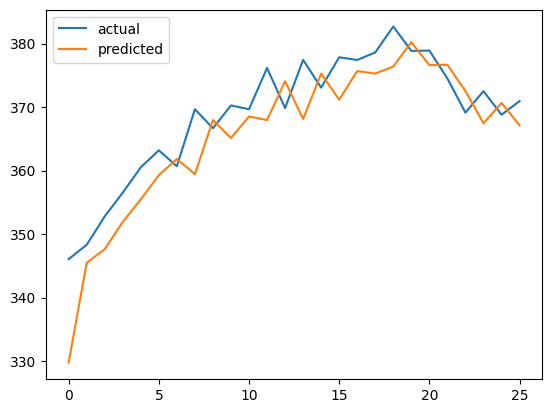

In [29]:
plt.plot(future_data, label = 'actual')
plt.plot(future_predictions, label = 'predicted')
plt.legend()
plt.show()

In [30]:
def get_control_vector(val):
    return np.diff(np.sign(np.diff(val)))

def buy_and_sell_bot(val,controls):
    inv = []
    curr_val = 1000
    inds = np.where(controls)[0]
    buy_inds = np.where(controls>0)[0]
    sell_inds = np.where(controls<0)[0]
    max_limit = sell_inds[-1] if sell_inds[-1]>buy_inds[-1] else buy_inds[-1]
    for i in range(buy_inds[0]+2):
        inv.append(curr_val)
    for i in range(buy_inds[0],max_limit+1):
        if controls[i]>0:
            buy_val = val[i+1]
        elif controls[i]<0:
            sell_val = val[i+1]
            curr_val = curr_val*sell_val/buy_val
        inv.append(curr_val)
        
    if max_limit+1!=len(controls):
        for i in range(len(controls)-max_limit-1):
            inv.append(curr_val)
    return inv

In [31]:
controls_actual = get_control_vector(future_data)
amount_actual = buy_and_sell_bot(future_data, controls_actual)

In [32]:
controls_pred= get_control_vector(future_predictions)
amount_pred = buy_and_sell_bot(future_predictions, controls_pred)

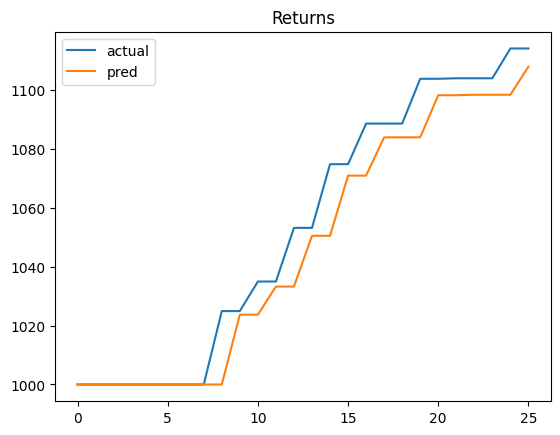

In [33]:
plt.plot(amount_actual, label="actual")
plt.plot(amount_pred, label="pred")
plt.legend()
plt.title("Returns")
plt.show()